Path to dataset files: /kaggle/input/foggy-images

=== Dataset Structure Exploration ===
Root path: /kaggle/input/foggy-images
Items in root directory: ['IMG-20230220-WA0042.jpg', 'IMG-20230220-WA0049.jpg', 'IMG-20230220-WA0060.jpg', 'IMG-20230220-WA0037.jpg', 'IMG-20230220-WA0035.jpg', 'IMG-20230220-WA0058.jpg', 'IMG-20230220-WA0043.jpg', 'IMG-20230220-WA0048.jpg', 'IMG-20230220-WA0050.jpg', 'IMG-20230220-WA0028.jpg', 'IMG-20230220-WA0070.jpg', 'IMG-20230220-WA0066.jpg', 'IMG-20230220-WA0055.jpg', 'IMG-20230220-WA0045.jpg', 'IMG-20230220-WA0046.jpg', 'IMG-20230220-WA0034.jpg', 'IMG-20230220-WA0047.jpg', 'IMG-20230220-WA0033.jpg', 'IMG-20230220-WA0051.jpg', 'IMG-20230220-WA0039.jpg', 'IMG-20230220-WA0017.jpg', 'IMG-20230220-WA0036.jpg', 'IMG-20230220-WA0059.jpg', 'IMG-20230220-WA0054.jpg', 'IMG-20230220-WA0057.jpg', 'IMG-20230220-WA0053.jpg', 'IMG-20230220-WA0064.jpg', 'IMG-20230220-WA0068.jpg', 'IMG-20230220-WA0056.jpg', 'IMG-20230220-WA0038.jpg', 'IMG-20230220-WA0063.jpg', 'IMG-20230

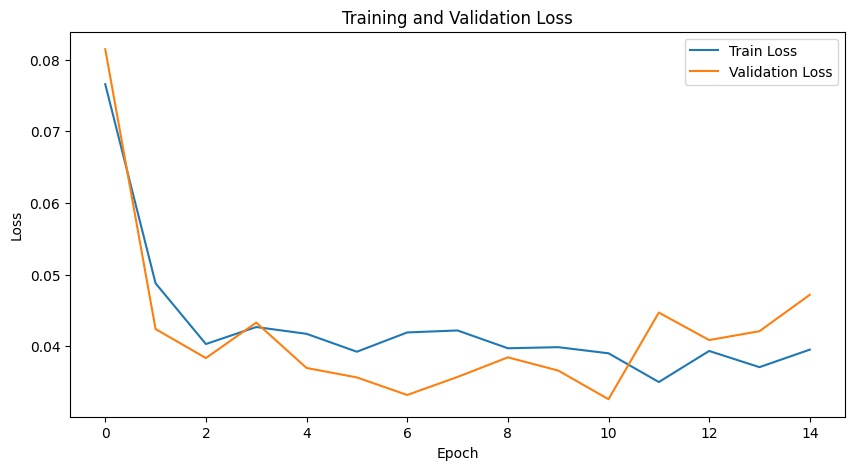

Model saved as 'simple_dehazing_model.pth'

Visualizing results...


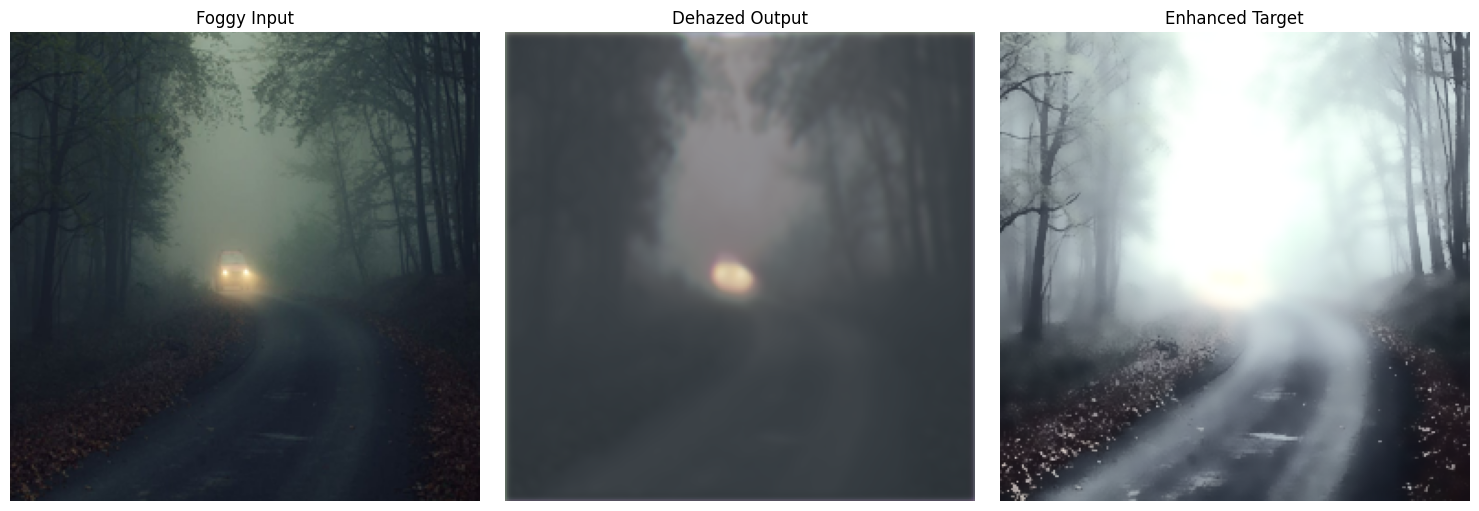

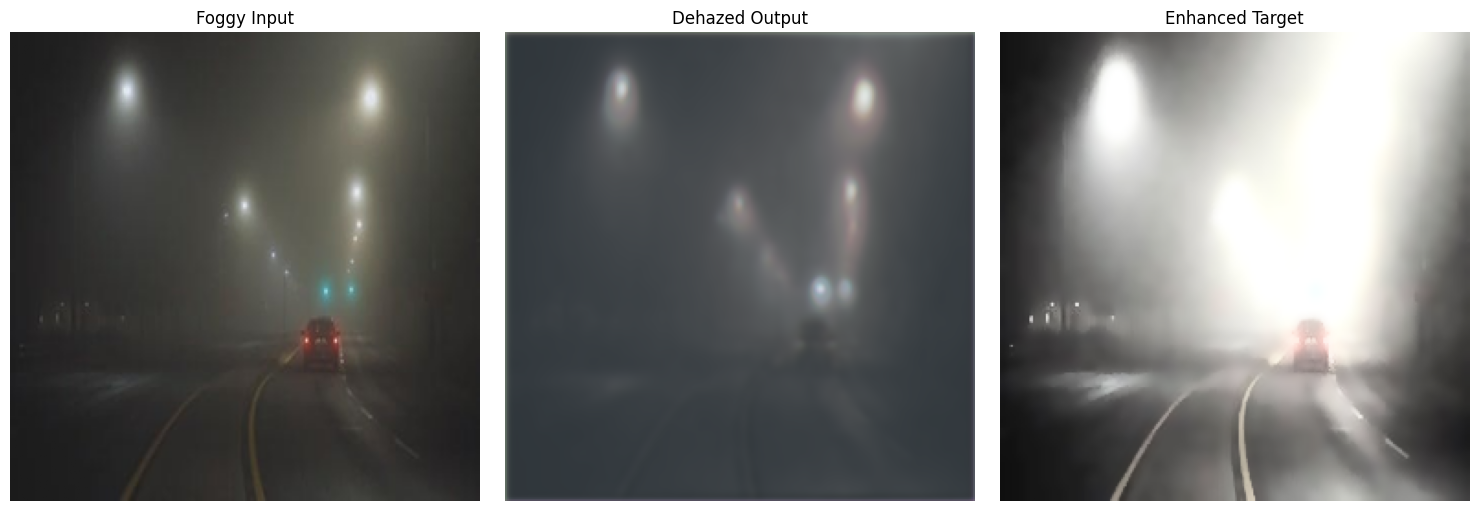

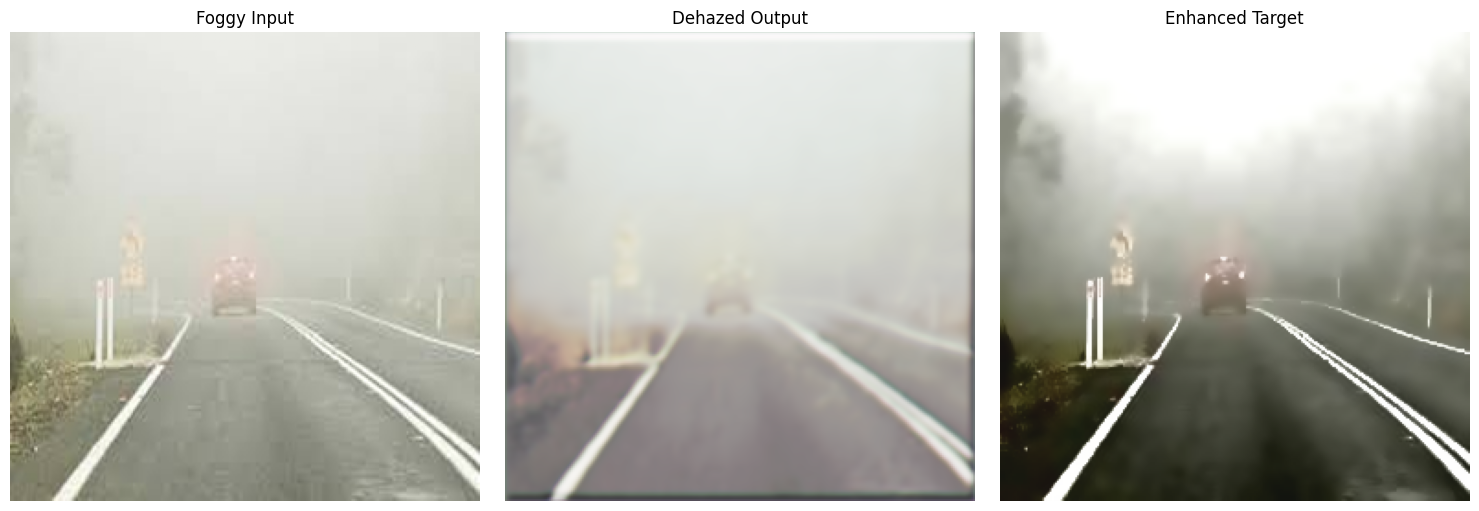

Training completed successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import kagglehub
import cv2
import warnings
warnings.filterwarnings('ignore')

# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("sanghavig/foggy-images")
print("Path to dataset files:", path)

def explore_dataset(path):
    """Explore and understand the dataset structure"""
    print("\n=== Dataset Structure Exploration ===")
    print(f"Root path: {path}")

    if not os.path.exists(path):
        print("ERROR: Dataset path does not exist!")
        return None

    # List all items in the root directory
    items = os.listdir(path)
    print(f"Items in root directory: {items}")

    # Look for image files and subdirectories
    image_files = []
    subdirs = []

    for item in items:
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            subdirs.append(item)
            # Check for images in subdirectories
            try:
                sub_items = os.listdir(item_path)
                sub_images = [f for f in sub_items if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                if sub_images:
                    print(f"  Subdirectory '{item}' contains {len(sub_images)} image files")
                    print(f"    Sample files: {sub_images[:3]}")
            except:
                pass
        elif item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_files.append(item)

    # Check for images in root directory
    if image_files:
        print(f"Found {len(image_files)} image files in root directory")
        print(f"Sample files: {image_files[:3]}")
        return path, image_files

    # If no images in root, try subdirectories
    for subdir in subdirs:
        subdir_path = os.path.join(path, subdir)
        try:
            sub_items = os.listdir(subdir_path)
            sub_images = [f for f in sub_items if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            if sub_images:
                print(f"Using images from subdirectory: {subdir}")
                return subdir_path, sub_images
        except:
            continue

    print("ERROR: No image files found in dataset!")
    return None, []

class SimpleDataset(Dataset):
    def __init__(self, image_dir, image_files, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform
        self.image_size = image_size

        print(f"Dataset created with {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            # Load image
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            image = Image.open(img_path).convert('RGB')

            # Resize image
            image = image.resize(self.image_size, Image.LANCZOS)

            # Create enhanced version as target
            enhanced = self.enhance_image(image)

            if self.transform:
                image = self.transform(image)
                enhanced = self.transform(enhanced)

            return image, enhanced
        except Exception as e:
            print(f"Error loading image {self.image_files[idx]}: {e}")
            # Return dummy data if image fails to load
            dummy = torch.zeros(3, self.image_size[0], self.image_size[1])
            return dummy, dummy

    def enhance_image(self, image):
        try:
            # Convert to numpy array
            img_np = np.array(image)

            # Apply histogram equalization on Y channel
            img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

            # Increase contrast and brightness
            enhanced = cv2.convertScaleAbs(enhanced, alpha=1.1, beta=15)

            enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

            return Image.fromarray(enhanced)
        except Exception as e:
            print(f"Error enhancing image: {e}")
            return image

class SimpleDehazingCNN(nn.Module):
    def __init__(self):
        super(SimpleDehazingCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Processing blocks
        self.processing = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        enc_out = self.encoder(x)

        # Processing
        proc_out = self.processing(enc_out)

        # Decoder
        output = self.decoder(proc_out)

        return output

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_batches = 0

        for batch_idx, (foggy, clear) in enumerate(train_loader):
            try:
                foggy, clear = foggy.to(device), clear.to(device)

                optimizer.zero_grad()
                output = model(foggy)
                loss = criterion(output, clear)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_batches += 1

                if batch_idx % 5 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')
            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for foggy, clear in val_loader:
                try:
                    foggy, clear = foggy.to(device), clear.to(device)
                    output = model(foggy)
                    loss = criterion(output, clear)
                    val_loss += loss.item()
                    val_batches += 1
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue

        if train_batches > 0:
            avg_train_loss = train_loss / train_batches
            train_losses.append(avg_train_loss)

        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
            val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print('-' * 50)

    return train_losses, val_losses

def visualize_results(model, test_loader, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for i, (foggy, clear) in enumerate(test_loader):
            if i >= num_samples:
                break

            try:
                foggy, clear = foggy.to(device), clear.to(device)
                output = model(foggy)

                foggy_np = foggy.cpu().numpy().transpose(0, 2, 3, 1)
                clear_np = clear.cpu().numpy().transpose(0, 2, 3, 1)
                output_np = output.cpu().numpy().transpose(0, 2, 3, 1)

                # Clip values to [0, 1]
                foggy_np = np.clip(foggy_np, 0, 1)
                clear_np = np.clip(clear_np, 0, 1)
                output_np = np.clip(output_np, 0, 1)

                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                axes[0].imshow(foggy_np[0])
                axes[0].set_title('Foggy Input')
                axes[0].axis('off')

                axes[1].imshow(output_np[0])
                axes[1].set_title('Dehazed Output')
                axes[1].axis('off')

                axes[2].imshow(clear_np[0])
                axes[2].set_title('Enhanced Target')
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error visualizing sample {i}: {e}")
                continue

def main():
    try:
        # Explore dataset structure
        dataset_info = explore_dataset(path)
        if dataset_info is None or dataset_info[0] is None:
            print("Cannot proceed without valid dataset")
            return None

        image_dir, image_files = dataset_info

        if len(image_files) < 10:
            print(f"Warning: Only {len(image_files)} images found. This may not be enough for training.")

        # Set up data transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Create dataset
        dataset = SimpleDataset(
            image_dir=image_dir,
            image_files=image_files,
            transform=transform,
            image_size=(256, 256)
        )

        # Split dataset
        dataset_size = len(dataset)
        train_size = max(1, int(0.7 * dataset_size))
        val_size = max(1, int(0.2 * dataset_size))
        test_size = max(1, dataset_size - train_size - val_size)

        print(f"Dataset split - Train: {train_size}, Val: {val_size}, Test: {test_size}")

        train_dataset, temp_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size + test_size]
        )
        val_dataset, test_dataset = torch.utils.data.random_split(
            temp_dataset, [val_size, test_size]
        )

        # Create data loaders
        batch_size = min(4, len(train_dataset))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

        # Initialize model
        model = SimpleDehazingCNN()
        print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

        # Train model
        print("\nStarting training...")
        train_losses, val_losses = train_model(
            model, train_loader, val_loader,
            num_epochs=15, learning_rate=0.001
        )

        # Plot training curves
        if train_losses and val_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.show()

        # Save model
        torch.save(model.state_dict(), 'simple_dehazing_model.pth')
        print("Model saved as 'simple_dehazing_model.pth'")

        # Visualize results
        print("\nVisualizing results...")
        visualize_results(model, test_loader, num_samples=min(3, len(test_dataset)))

        return model

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    model = main()
    if model is not None:
        print("Training completed successfully!")
    else:
        print("Training failed. Please check the errors above.")